- [ ] Why the errors are better than the article?
- [ ] Cut the y-axis of the plot
- [ ] Check the data like in the paper

# Selection of Calibration Windows for Day-Ahead Electricity Price Forecasting
by Grzegorz Marcjasz, Tomasz Serafin and Rafał Weron 

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation

## Data Preparation


In [2]:
df_day_ahead_epex = pd.read_csv('Day_Ahead_Epex.csv', sep=';')
df_NP2018_complete = pd.read_csv('NP2018_complete.csv')
# remove the first column
df_NP2018_complete = df_NP2018_complete.iloc[:,1:]
df_PJM = pd.read_csv('PJM.csv', sep=';')

In [3]:
def normalize_prices_and_vst(prices):
    a = np.median(prices)
    b = median_abs_deviation(prices)
    p = 1/b * (prices - a)
    X = np.arcsinh(p)
    return p, a, b, X

def inverse_transform(forecast, a, b): # apply the inverse of VST to the forecast to obtain the price prediction
    price_predictions = b * np.sinh(forecast) + a
    return price_predictions

### df_NP2018

In [4]:
df_NP2018_complete['sunday'] = np.where(df_NP2018_complete['Day'] == 7, 1, 0)
df_NP2018_complete['saturday'] = np.where(df_NP2018_complete['Day'] == 6, 1, 0)
df_NP2018_complete['monday'] = np.where(df_NP2018_complete['Day'] ==  1, 1, 0)

In [5]:
df_NP2018_complete.head()

,Date,Hour,Price,load,placeholder2,Day,sunday,saturday,monday
0,20130101,1,31.05,42497.0,2798.0,2,0,0,0
1,20130101,2,30.47,41463.0,2417.0,2,0,0,0
2,20130101,3,28.92,40812.0,2036.0,2,0,0,0
3,20130101,4,27.88,40246.0,1706.0,2,0,0,0
4,20130101,5,26.96,40088.0,1427.0,2,0,0,0


### df_PJM

In [6]:
df_PJM['sunday'] = np.where(df_PJM['day'] == 7, 1, 0)
df_PJM['saturday'] = np.where(df_PJM['day'] == 6, 1, 0)
df_PJM['monday'] = np.where(df_PJM['day'] ==  1, 1, 0)

In [7]:
price = df_PJM["comed price"]
exogenos = df_PJM["rto load forecast"]
sunday = df_PJM["sunday"]
saturday = df_PJM["saturday"]
monday = df_PJM["monday"]
df_PJM['Min_Comed_Price'] = df_PJM.groupby('date')['comed price'].transform('min')
df_PJM['Max_Comed_Price'] = df_PJM.groupby('date')['comed price'].transform('max')

In [8]:
df_PJM.head()

,date,hour,comed price,rto load forecast,comed load foecast,day,sunday,saturday,monday,Min_Comed_Price,Max_Comed_Price
0,20110102,0,17.141179,68590.0,11432.0,1,0,0,1,10.690926,51.389987
1,20110102,1,14.179616,65896.0,10862.0,1,0,0,1,10.690926,51.389987
2,20110102,2,12.736793,64511.0,10486.0,1,0,0,1,10.690926,51.389987
3,20110102,3,11.096262,63935.0,10318.0,1,0,0,1,10.690926,51.389987
4,20110102,4,10.690926,64321.0,10208.0,1,0,0,1,10.690926,51.389987


### df_day_ahead_epex

In [9]:
df_day_ahead_epex['sunday'] = np.where(df_day_ahead_epex['day'] == 7, 1, 0)
df_day_ahead_epex['saturday'] = np.where(df_day_ahead_epex['day'] == 6, 1, 0)
df_day_ahead_epex['monday'] = np.where(df_day_ahead_epex['day'] ==  1, 1, 0)

In [10]:
price = df_day_ahead_epex["Spot DE.AT_price"]
# exogenos = df_day_ahead_epex["rto load forecast"]
sunday = df_day_ahead_epex["sunday"]
saturday = df_day_ahead_epex["saturday"]
monday = df_day_ahead_epex["monday"]
df_day_ahead_epex['Min_Comed_Price'] = df_day_ahead_epex.groupby('Date')['Spot DE.AT_price'].transform('min')
df_day_ahead_epex['Max_Comed_Price'] = df_day_ahead_epex.groupby('Date')['Spot DE.AT_price'].transform('max')

In [11]:
df_day_ahead_epex.head()

,Date,hour,Spot DE.AT_price,day,sunday,saturday,monday,Min_Comed_Price,Max_Comed_Price
0,20150101,1,25.02,5,0,0,0,0.04,26.9
1,20150101,2,18.29,5,0,0,0,0.04,26.9
2,20150101,3,16.04,5,0,0,0,0.04,26.9
3,20150101,4,14.60,5,0,0,0,0.04,26.9
4,20150101,5,14.95,5,0,0,0,0.04,26.9


## ARX1

### df_PJM

#### Raw Data

In [ ]:
load = df_PJM["rto load forecast"]

errors_mean_ARX1_PJM_Raw = []

for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_PJM.loc[h::24,'comed price'].values # hourly data selection
        exogenos = df_PJM.loc[h::24,'rto load forecast'].values
        sunday = df_PJM.loc[h::24,'sunday'].values
        monday = df_PJM.loc[h::24,'monday'].values
        saturday = df_PJM.loc[h::24,'saturday'].values
        c_d_min = df_PJM.loc[h::24,'Min_Comed_Price'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                cal_data = price[(day-T):day].values
                
                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = exogenos[7:T]  #C_d_h
                X6 = sunday[7:T] # sunday
                X7 = monday[7:T] # monday
                X8 = saturday[7:T] # saturday
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], exogenos[day],sunday[day],monday[day],saturday[day]])
                forecast = np.dot(X_fut,betas)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)
        
    errors_mean_ARX1_PJM_Raw.append(np.mean(errors))

print(errors_mean_ARX1_PJM_Raw)

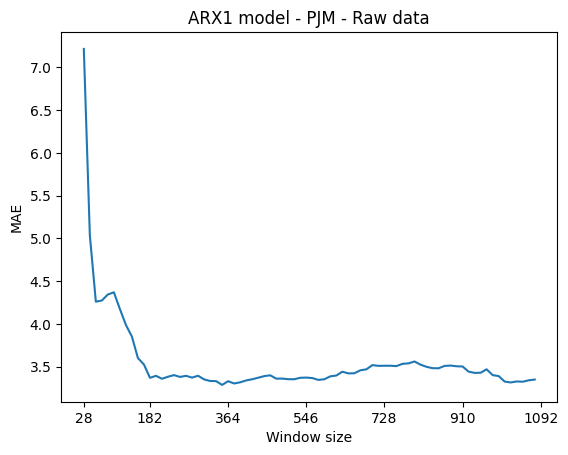

In [16]:
window_size = list(range(28,1092,14))
plt.plot(window_size, errors_mean_ARX1_PJM_Raw)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX1 model - PJM - Raw data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
# plt.grid()
plt.ylim(0, 4)
plt.show()

#### Normalized

In [17]:
df_PJM["min_norm"] = df_PJM.groupby('date')['comed price'].transform('min')
df_PJM["max_norm"] = df_PJM.groupby('date')['comed price'].transform('max')

In [ ]:
load = df_PJM["rto load forecast"]

errors_mean_ARX1_PJM_Norm = []

for T in range(28,1092,14):
    errors = []
    
    for h in range(24):
        p_hour = df_PJM.loc[h::24,'comed price'].values # hourly data selection
        exogenos = df_PJM.loc[h::24,'rto load forecast'].values
        sunday = df_PJM.loc[h::24,'sunday'].values
        monday = df_PJM.loc[h::24,'monday'].values
        saturday = df_PJM.loc[h::24,'saturday'].values
        c_d_min = df_PJM.loc[h::24,'min_norm'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                
                cal_data = price[(day-T):day].values # calibration data
                
                p, a, b, cal_data = normalize_prices_and_vst(cal_data)

                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = exogenos[7:T]  #C_d_h
                X6 = sunday[7:T] # sunday
                X7 = monday[7:T] # monday
                X8 = saturday[7:T] # saturday
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], exogenos[day],sunday[day],monday[day],saturday[day]])

                forecast = np.dot(X_fut,betas)
                # Apply inverse transformation to the forecast
                forecast = inverse_transform(forecast, a, b)
                forecasts.append(forecast)
            
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)

    errors_mean_ARX1_PJM_Norm.append(np.mean(errors))

In [ ]:
print(errors_mean_ARX1_PJM_Norm)
window_list = list(range(28,1092,14))
plt.plot(window_list, errors_mean_ARX1_PJM_Norm)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX1 model - PJM - Normalized data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 4)
plt.show()

### df_NP2018_complete

#### Raw Data

In [20]:
price = df_NP2018_complete["Price"]
exogenos = df_NP2018_complete["load"]
sunday = df_NP2018_complete["sunday"]
saturday = df_NP2018_complete["saturday"]
monday = df_NP2018_complete["monday"]
df_NP2018_complete['Min_Comed_Price'] = df_NP2018_complete.groupby('Date')['Price'].transform('min')
df_NP2018_complete['Max_Comed_Price'] = df_NP2018_complete.groupby('Date')['Price'].transform('max')

In [ ]:
df_NP2018_complete.head()

[6.564818484616738, 5.0425482550463965, 2.9022485781871152, 3.6263526241279678, 2.918519512946473, 2.885224050604717, 2.152392372817417, 1.9837470603861982, 1.898929829522265, 1.839355953566575, 1.8031119251656744, 1.7552598457133939, 1.7533709148861294, 1.7477863892569718, 1.7561433774216528, 1.7501934217416333, 1.7537915605870724, 1.7863744298726498, 1.7940974679034163, 1.7899814452703258, 1.7627695726302666, 1.7213237722006782, 1.6819727919025453, 1.6231192770388088, 1.5908052409659112, 1.5558244528195966, 1.536767152795938, 1.5157137178486444, 1.5127870890257578, 1.5145173169882824, 1.5175469929480658, 1.5173417745784687, 1.4964131475917763, 1.4825003166749666, 1.481957237426784, 1.4357454296463432, 1.3883440011750663, 1.361623383358631, 1.333239520028474, 1.2961027115500552, 1.293832219981566, 1.2940325122080871, 1.3229958260992474, 1.3253623005513155, 1.3250438861357918, 1.3129353842320532, 1.293077375156529, 1.2765682674136405, 1.2617147169376826, 1.25422548401556, 1.24148515094

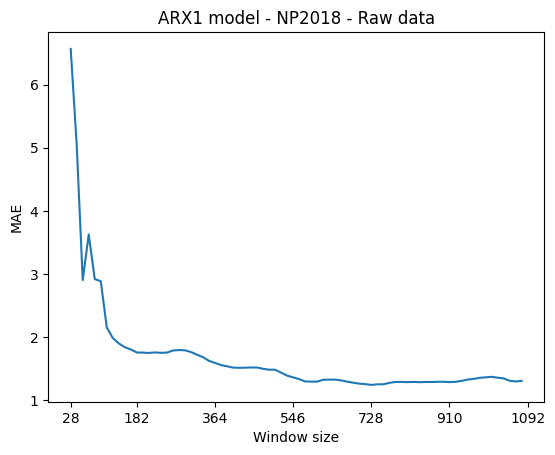

In [21]:
load = df_NP2018_complete["load"]

errors_mean_ARX1_NP_Raw = []

window_list = list(range(35, 1093, 7))

for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_NP2018_complete.loc[h::24,'Price'].values # hourly data selection
        exogenos = df_NP2018_complete.loc[h::24,'load'].values
        sunday = df_NP2018_complete.loc[h::24,'sunday'].values
        monday = df_NP2018_complete.loc[h::24,'monday'].values
        saturday = df_NP2018_complete.loc[h::24,'saturday'].values
        c_d_min = df_NP2018_complete.loc[h::24,'Min_Comed_Price'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                cal_data = price[(day-T):day].values # calibration data 
                
                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = exogenos[7:T]  #C_d_h
                X6 = sunday[7:T] # sunday
                X7 = monday[7:T] # monday
                X8 = saturday[7:T] # saturday
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], exogenos[day],sunday[day],monday[day],saturday[day]])

                forecast = np.dot(X_fut,betas)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)
                
    errors_mean_ARX1_NP_Raw.append(np.mean(errors))

print(errors_mean_ARX1_NP_Raw)

In [ ]:
window_list = list(range(28,1092,14))
plt.plot(window_list, errors_mean_ARX1_NP_Raw)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX1 model - NP2018 - Raw data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
# plt.grid()
plt.ylim(0, 3)
plt.show()

#### Normalized


In [22]:
df_NP2018_complete["min_norm"] = df_NP2018_complete.groupby('Date')['Price'].transform('min')
df_NP2018_complete["max_norm"] = df_NP2018_complete.groupby('Date')['Price'].transform('max')

[457.03346912722515, 7.478465939820975, 3.2960379037078575, 8.96607766696933, 2.1184039218593402, 2.0419529845175073, 1.7771122083479223, 1.6338865534504607, 1.5928622968530923, 1.5268077787238505, 1.515240108005157, 1.4876936062635853, 1.476059424269117, 1.4777816928278407, 1.4869440559693827, 1.4875166512595315, 1.5030959649044957, 1.521107515737586, 1.5329101346465996, 1.5348639568703646, 1.521574761781807, 1.5050200055600143, 1.494644287024215, 1.4396905453397346, 1.4150352480566508, 1.365104723025265, 1.3504287642943502, 1.3067087966038835, 1.294809771235361, 1.2900197498224577, 1.2977091055119203, 1.293120458059899, 1.2956394999152037, 1.300760363873945, 1.3002519192919637, 1.2671167041836588, 1.2349548292892878, 1.1856279557704192, 1.1650236885029817, 1.090616615379811, 1.0774192000428506, 1.0650824322385175, 1.0779826409964917, 1.0819063294434756, 1.0898219783897487, 1.0962909067747624, 1.1011539665817942, 1.0979083583644857, 1.0933761126873467, 1.0994486864340616, 1.0983318399

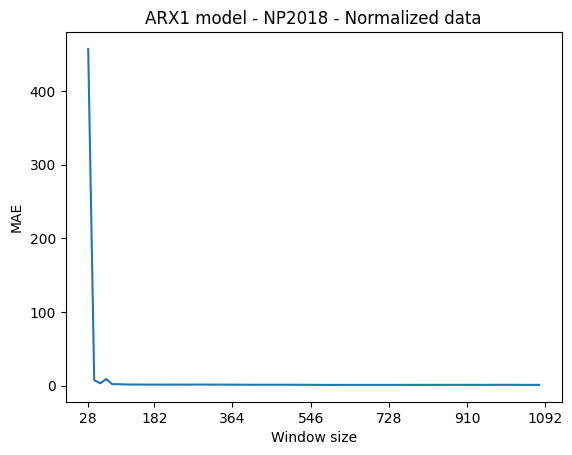

In [25]:
load = df_NP2018_complete["load"]

errors_mean_ARX1_NP_Norm = []

for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_NP2018_complete.loc[h::24,'Price'].values # hourly data selection
        exogenos = df_NP2018_complete.loc[h::24,'load'].values
        sunday = df_NP2018_complete.loc[h::24,'sunday'].values
        monday = df_NP2018_complete.loc[h::24,'monday'].values
        saturday = df_NP2018_complete.loc[h::24,'saturday'].values
        c_d_min = df_NP2018_complete.loc[h::24,'min_norm'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                
                cal_data = price[(day-T):day].values # calibration data
                p, a, b, cal_data = normalize_prices_and_vst(cal_data)
                
                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = exogenos[7:T]  #C_d_h
                X6 = sunday[7:T] # sunday
                X7 = monday[7:T] # monday
                X8 = saturday[7:T] # saturday
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], exogenos[day],sunday[day],monday[day],saturday[day]])

                # forecast = np.dot(X_fut,betas)
                # forecasts.append(forecast)
                forecast = np.dot(X_fut,betas)
                # Apply inverse transformation to the forecast
                forecast = inverse_transform(forecast, a, b)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)
    
    errors_mean_ARX1_NP_Norm.append(np.mean(errors))

print(errors_mean_ARX1_NP_Norm)

In [ ]:
window_list = list(range(28,1092,14))
plt.plot(window_list, errors_mean_ARX1_NP_Norm)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX1 model - NP2018 - Normalized data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 3)
plt.show()

### df_day_ahead_epex

#### Raw Data

#### Normalized

## ARX2

### df_PJM

#### Raw Data

[8.076848185790832, 5.708198620977739, 4.684807057473799, 4.503645264349472, 4.592795571059487, 4.505837244795178, 4.3118725140603456, 4.214567281172071, 4.108108396969856, 4.07779509849173, 3.688322626114573, 3.538196223725599, 3.460446232951574, 3.419587927018845, 3.485703976753004, 3.469724418623769, 3.4614530832007544, 3.452949219016686, 3.4313734154149254, 3.4647675676603624, 3.4266613905402687, 3.4014070150995455, 3.3910495226289354, 3.343389225470367, 3.360723626988636, 3.3250274374214213, 3.353674173001582, 3.359751398881624, 3.3885267399933974, 3.408995811368776, 3.4232558016915036, 3.429187808503025, 3.3982322168150936, 3.4176158876795175, 3.4010608471022903, 3.402455791982714, 3.4113529434572403, 3.3997091501630172, 3.395289500629078, 3.3720491377672857, 3.383570569180874, 3.4210464804196263, 3.425447907770217, 3.472788813070113, 3.4488298574824934, 3.4685013357395666, 3.487394674141709, 3.509150955300803, 3.5377767849775097, 3.5331531015245945, 3.5244313110635117, 3.5303222

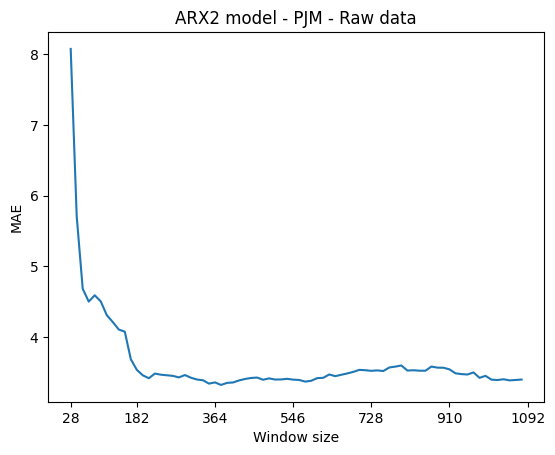

In [18]:
load = df_PJM["rto load forecast"]
df_PJM["for_d_1"] = df_PJM["comed price"].shift(1)

errors_mean_ARX2_PJM_Raw = []


T = 28
for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_PJM.loc[h::24,'comed price'].values # hourly data selection
        exogenos = df_PJM.loc[h::24,'rto load forecast'].values
        weekday = df_PJM.loc[h::24,'day'].values
        c_d_min = df_PJM.loc[h::24,'Min_Comed_Price'].values
        c_d_max = df_PJM.loc[h::24,'Max_Comed_Price'].values
        for_d_1 = df_PJM.loc[h::24,'for_d_1'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                cal_data = price[(day-T):day].values # calibration data 
                
                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = c_d_max[7:T]  #C_d_h
                X6 = for_d_1[7:T] # c_d-1_24
                X7 = exogenos[7:T]
                X8 = weekday[7:T] 
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], c_d_max[day], for_d_1[day], exogenos[day],weekday[day]])

                forecast = np.dot(X_fut,betas)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)

    errors_mean_ARX2_PJM_Raw.append(np.mean(errors))

print(errors_mean_ARX2_PJM_Raw)

In [ ]:
window_list = list(range(28,1092,14))
plt.plot(window_list, errors_mean_ARX2_PJM_Raw)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX2 model - PJM - Raw data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 4)
plt.show()

#### Normalized

In [ ]:
df_PJM.head()

In [ ]:
df_PJM["min"] = df_PJM.groupby('date')['comed price'].transform('min')
df_PJM["max"] = df_PJM.groupby('date')['comed price'].transform('max')

In [ ]:
load = df_PJM["rto load forecast"]
df_PJM["for_d_1_norm"] = df_PJM["comed price"].shift(1)

errors_mean_ARX2_PJM_Norm = []


for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_PJM.loc[h::24,'comed price'].values # hourly data selection
        exogenos = df_PJM.loc[h::24,'rto load forecast'].values
        weekday = df_PJM.loc[h::24,'day'].values
        c_d_min = df_PJM.loc[h::24,'min'].values
        c_d_max = df_PJM.loc[h::24,'max'].values
        for_d_1 = df_PJM.loc[h::24,'for_d_1_norm'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                cal_data = price[(day-T):day].values # calibration data
                p, a, b, cal_data = normalize_prices_and_vst(cal_data)

                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = c_d_max[7:T]  #C_d_h
                X6 = for_d_1[7:T] # c_d-1_24
                X7 = exogenos[7:T]
                X8 = weekday[7:T] 
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], c_d_max[day], for_d_1[day], exogenos[day],weekday[day]])

                forecast = np.dot(X_fut,betas)
                # Apply inverse transformation to the forecast
                forecast = inverse_transform(forecast, a, b)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)

    errors_mean_ARX2_PJM_Norm.append(np.mean(errors))

In [ ]:
print(errors_mean_ARX2_PJM_Norm)
window_list = list(range(28,1092,14))
plt.plot(window_list, errors_mean_ARX2_PJM_Norm)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX2 model - PJM - Normalized data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 4)
plt.show()

### df_NP2018_complete

In [ ]:
df_NP2018_complete.head()

#### Raw Data

In [ ]:
load = df_NP2018_complete["load"]
df_NP2018_complete["for_d_1"] = df_NP2018_complete["Price"].shift(1)

errors_mean_ARX2_NP_Raw = []

window_list = list(range(35, 1093, 7))

for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_NP2018_complete.loc[h::24,'Price'].values # hourly data selection
        exogenos = df_NP2018_complete.loc[h::24,'load'].values
        weekday = df_NP2018_complete.loc[h::24,'Day'].values
        c_d_min = df_NP2018_complete.loc[h::24,'Min_Comed_Price'].values
        c_d_max = df_NP2018_complete.loc[h::24,'Max_Comed_Price'].values
        for_d_1 = df_NP2018_complete.loc[h::24,'for_d_1'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24):
                cal_data = price[(day-T):day].values # calibration data 
                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = c_d_max[7:T]  #C_d_h
                X6 = for_d_1[7:T] # c_d-1_24
                X7 = exogenos[7:T]
                X8 = weekday[7:T] 
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], c_d_max[day], for_d_1[day], exogenos[day],weekday[day]])
                forecast = np.dot(X_fut,betas)
                forecasts.append(forecast)
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)

    errors_mean_ARX2_NP_Raw.append(np.mean(errors))

print(errors_mean_ARX2_NP_Raw)

In [ ]:
plt.plot(window_list, errors_mean_ARX2_NP_Raw)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX2 model - NP2018 - Raw data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 3)
plt.show()

#### Normalized

In [ ]:
df_NP2018_complete.head()

In [ ]:
load = df_NP2018_complete["load"]
df_NP2018_complete["for_d_1_norm"] = df_NP2018_complete["Price"].shift(1)
errors = []
errors_mean_ARX2_NP_Norm = []

window_list = list(range(35, 1093, 7))

for T in range(28,1092,14):
    errors = []
    for h in range(24):
        p_hour = df_NP2018_complete.loc[h::24,'Price'].values # hourly data selection
        exogenos = df_NP2018_complete.loc[h::24,'load'].values
        weekday = df_NP2018_complete.loc[h::24,'Day'].values
        c_d_min = df_NP2018_complete.loc[h::24,'min_norm'].values
        c_d_max = df_NP2018_complete.loc[h::24,'max_norm'].values
        for_d_1 = df_NP2018_complete.loc[h::24,'for_d_1_norm'].values
        h_errors = []
        # Initialize an empty list to store the forecasts
        forecasts = []
        for day in range(T, len(price)//24)):
                cal_data = price[(day-T):day].values # calibration data
                p, a, b, cal_data = normalize_prices_and_vst(cal_data)

                Y = cal_data[7:T]
                X1 = cal_data[6:T-1] 
                X2 = cal_data[5:T-2] 
                X3 = cal_data[0:T-7]
                X4 = c_d_min[7:T]
                X5 = c_d_max[7:T]  #C_d_h
                X6 = for_d_1[7:T] # c_d-1_24
                X7 = exogenos[7:T]
                X8 = weekday[7:T] 
                X0 = np.ones(np.size(X1)) 
                X = np.stack([X0,X1,X2, X3,X4,X5, X6, X7, X8],axis = 1)
                betas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
                X_fut = np.array([1,cal_data[T-1],cal_data[T-2],cal_data[T-7],c_d_min[day], c_d_max[day], for_d_1[day], exogenos[day],weekday[day]])
                
                forecast = np.dot(X_fut,betas)
                # Apply inverse transformation to the forecast
                forecast = inverse_transform(forecast, a, b)
                forecasts.append(forecast)
                
                real = price[day]
                err = real - forecast
                errors1 = (np.abs(err))
                errors.append(errors1)

    errors_mean_ARX2_NP_Norm.append(np.mean(errors))

print(errors_mean_ARX2_NP_Norm)

In [ ]:
plt.plot(window_list, errors_mean_ARX2_NP_Norm)
plt.xlabel('Window size')
plt.ylabel('MAE')
plt.title('ARX2 model - NP2018 - Normalized data')
xticks = [28, 182, 364, 546, 728, 910, 1092]
plt.xticks(xticks)
plt.ylim(0, 3)
plt.show()

### df_day_ahead_epex

In [ ]:
df_day_ahead_epex.head()

#### Raw Data

#### Normalized